## Developing A Theoretical Understanding on the Limitations of ML interpretation methods

### Linear Regression

Let's start with a simple 10-variable regression problem. 

\begin{equation}
y = 2.0x_1 + 1.5x_2 + 1.2x_3 + 0.5x_4 + 0.2x_5 + x_6 + x_7 + x_8 + x_9 + x_{10} + \epsilon 
\end{equation}

where $x_i = \mathcal{U}(-1,1)$ and $\epsilon=\mathcal{N}(\mu=0, \sigma=0.1)$. In the special case where $\epsilon = 0$ (or at least sufficiently small), the predictor ranking is based on the magnitude of the coefficients.  

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import mintpy
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
random_state=np.random.RandomState(42)
n_examples = 1000
n_vars = 5 
weights = [2.0, 1.5, 1.2, 0.5, 0.2]
X = np.stack([random_state.uniform(0,1, size=n_examples) for _ in range(n_vars)], axis=-1)
feature_names = [f'X_{i+1}' for i in range(n_vars)]
X = pd.DataFrame(X, columns=feature_names)

error = np.random.normal(loc=0, scale=0.1, size=n_examples)
y = X.dot(weights)#+error

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.25)

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Learned Coefficients: ', lr.coef_)

Learned Coefficients:  [2.  1.5 1.2 0.5 0.2]


The coefficients approximate the true coefficients quite well given the error. 

In [4]:
myInterpreter = mintpy.InterpretToolkit(models=lr, model_names='Linear Regression', examples=X,targets=y,)

100%|██████████| 5/5 [00:00<00:00, 121.28it/s]


(<Figure size 900x750 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefe8aa94a8>)

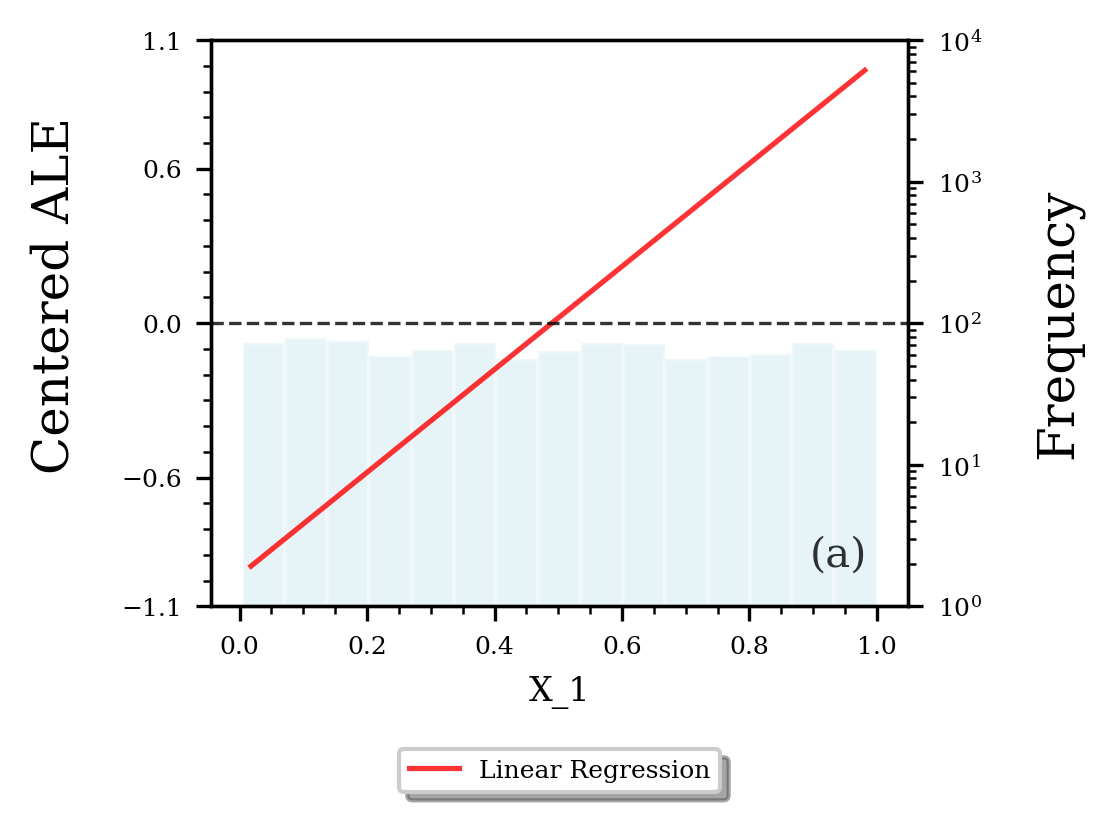

In [18]:
results = myInterpreter.calc_ale(features=feature_names, n_bins=30)
myInterpreter.plot_ale(features='X_1')

In [6]:
results['X_1__bin_values'].values
#[0.09082125, 0.27714732, 0.48378955, 0.6950751 , 0.89978646]

array([0.04810705, 0.13429628, 0.2289725 , 0.32910934, 0.43682521,
       0.54333059, 0.63934867, 0.74412883, 0.84971491, 0.94964612])

In [7]:
lr = LinearRegression()

print(np.shape(results['X_1__bin_values'].values), np.shape(results['X_1__Linear Regression__ale'][0]))



lr.fit(results['X_1__bin_values'].values.reshape(-1, 1), results['X_1__Linear Regression__ale'].values[0,:])
print(lr.coef_[0])

(10,) (10,)
1.999999999999998


In [8]:
results = myInterpreter.calc_permutation_importance(
                                               n_vars=len(feature_names), 
                                               evaluation_fn='mse', 
                                               n_bootstrap=1000, 
                                               subsample=1.0,
                                               n_jobs=10,
                                              )

In [9]:
results['multipass_rankings__Linear Regression']

<xarray.DataArray 'multipass_rankings__Linear Regression' (n_vars_multipass: 5)>
array(['X_1', 'X_2', 'X_3', 'X_4', 'X_5'], dtype='<U3')
Dimensions without coordinates: n_vars_multipass

In [10]:
ale_var_results = myInterpreter.calc_ale_variance(model_name='Linear Regression')

In [11]:
ale_var_results

<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 1, n_vars_ale_variance: 5)
Dimensions without coordinates: n_bootstrap, n_vars_ale_variance
Data variables:
    ale_variance_rankings__Linear Regression  (n_vars_ale_variance) <U3 'X_1'...
    ale_variance_scores__Linear Regression    (n_vars_ale_variance, n_bootstrap) float64 ...
Attributes:
    model_output:      raw
    models used:       Linear Regression
    method:            ale_variance
    dimension:         1D
    n_multipass_vars:  5
    perm_method:       marginal
    evaluation_fn:     mse
    model output:      probability

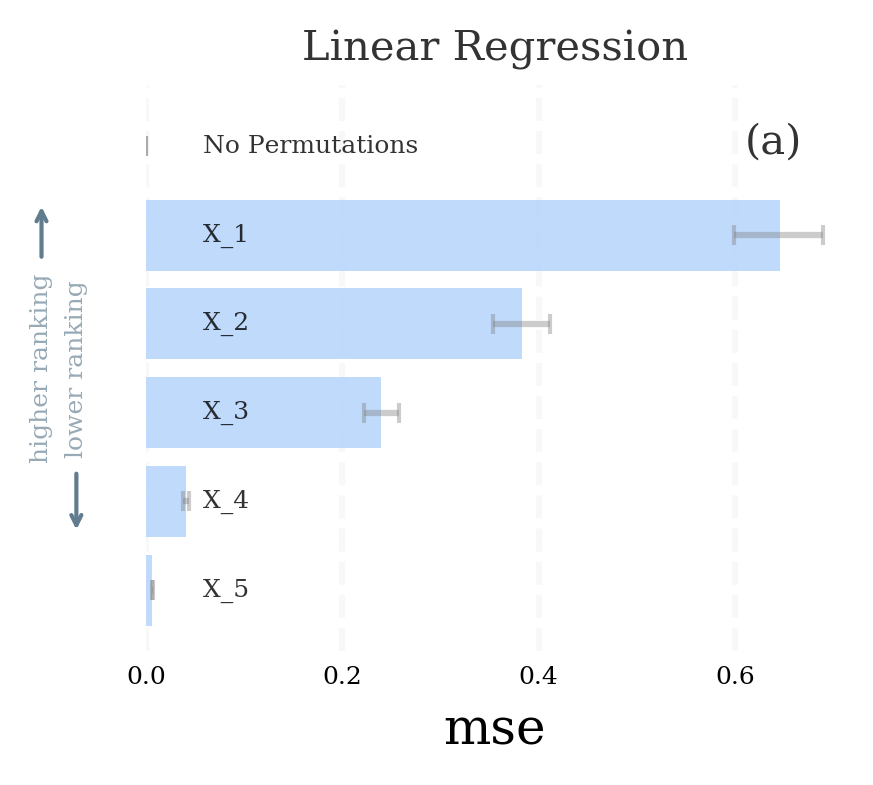

In [12]:
myInterpreter.plot_importance(method='singlepass')

Since the features are completely independent, the single-pass permutation method is good option for ranking the features. The results show the correct rankings: 
* $X_1$, $X_2$, and $X_3$ are the most important 
* $X_6-X_{10}$ have equivalent ranking (discerned by the CIs)
* $X_4-X_5$ are the least important

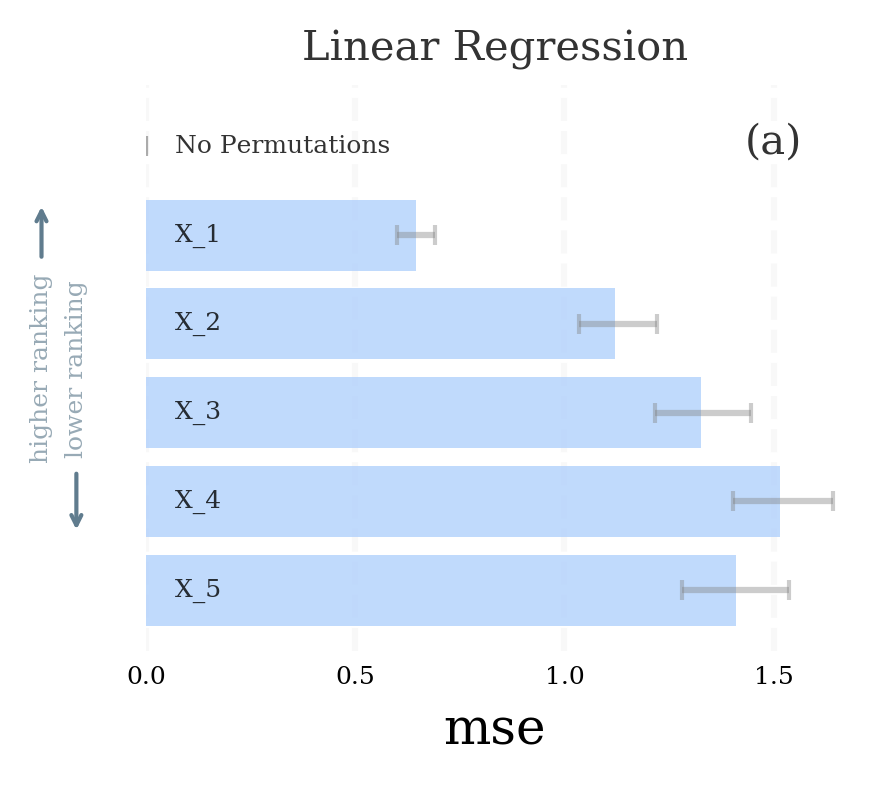

In [13]:
myInterpreter.plot_importance(method='multipass')

# Increasing error

The following test includes increasing the error and seeing if the rankings are altered. 

In [14]:
scales = np.arange(0.1, 1.7, 0.2)

ranked_features=[]
for s in scales:
    error = np.random.normal(loc=0, scale=s, size=n_examples)
    y = X.dot(weights)+error
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.25)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    results = myInterpreter.calc_permutation_importance(
                                               n_vars=len(feature_names), 
                                               evaluation_fn='mse', 
                                               n_bootstrap=100, 
                                               subsample=1.0,
                                               n_jobs=10,
                                              )
    ranked_features.append(results['multipass_rankings__Linear Regression'].values)

In [15]:
def get_avg_ranking(ranked_features, feature_names):
    """Compute the average rankings for a set of features"""
    
    rankings ={f:[] for f in feature_names}
    for rank in ranked_features:
        for f in feature_names:
            rankings[f].append(np.where(rank==f))
    
    for f in feature_names:
        rankings[f] = np.mean(rankings[f])
    
    return rankings

rankings = get_avg_ranking(ranked_features, feature_names)

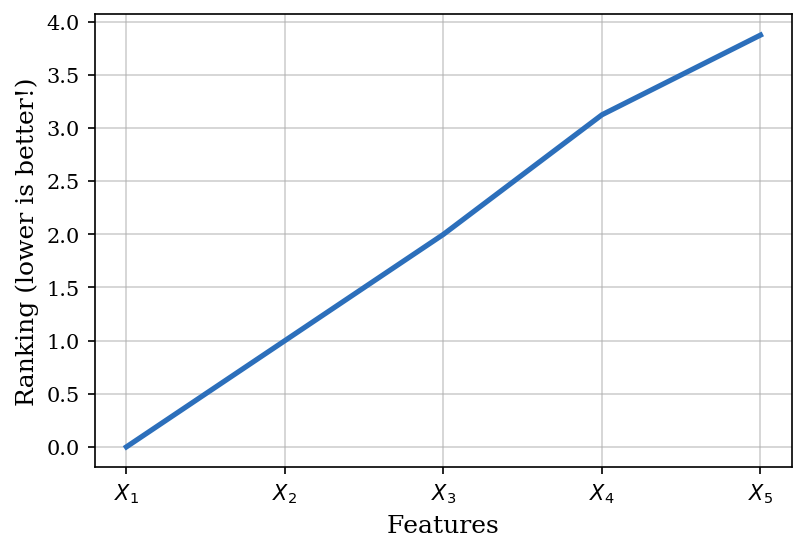

In [16]:
fig, ax = plt.subplots(dpi=150)
avg_rankings = [rankings[f] for f in feature_names]
ax.plot(np.arange(n_vars), avg_rankings, color='xkcd:medium blue', linewidth=2.5)
ax.set_xticks(np.arange(n_vars))
ax.set_xticklabels([f'${f}$' for f in feature_names])
ax.tick_params(labelsize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Ranking (lower is better!)')
ax.grid(alpha=0.6)

## Introducing colinearity 

Takeaways
*
*

ValueError: Shape of passed values is (1000, 4), indices imply (1000, 5)

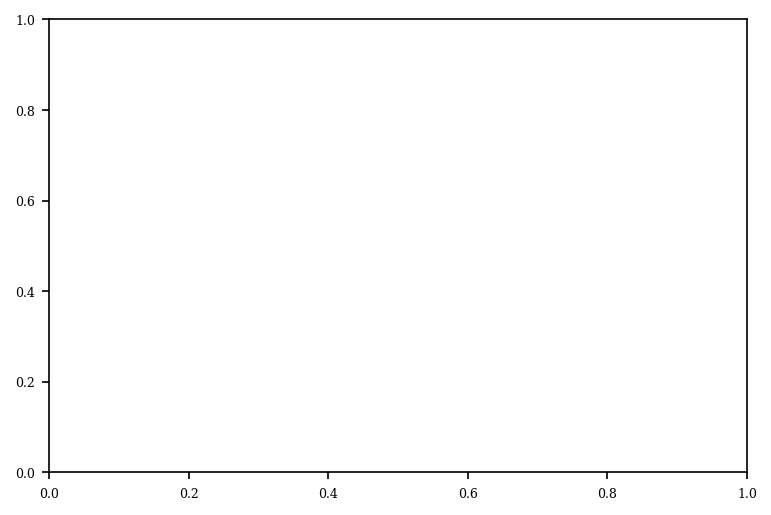

In [17]:
fig, ax = plt.subplots(dpi=150)

scales = np.arange(0.1, 1.0, 0.1)
for s in scales:
    data1 = [np.random.uniform(-1,1, size=n_examples) for _ in range(int(n_vars/2))]
    data2 = [d+np.random.normal(0,s, size=n_examples) for d in data1]

    X = np.stack(data1+data2, axis=-1)
    feature_names = [f'X_{i+1}' for i in range(n_vars)]
    X = pd.DataFrame(X, columns=feature_names)

    print(X.corr().abs()['X_1']['X_6'])
    
    error = np.random.normal(loc=0, scale=0.1, size=n_examples)
    y = X.dot(weights)+error
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.25)

    
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    myInterpreter = mintpy.InterpretToolkit(models=lr, 
                                            model_names='Linear Regression', 
                                            examples=X_train,targets=y_train,
                                           )
    
    results = myInterpreter.calc_permutation_importance(
                                               n_vars=len(feature_names), 
                                               evaluation_fn='mse', 
                                               n_bootstrap=100, 
                                               subsample=1.0,
                                               n_jobs=10,
                                              )
    
    rankings = results['multipass_rankings__Linear Regression'].values
    ranked_features.append(rankings)
    rankings = [np.where(rankings==f)[0] for f in feature_names]
    
    ax.plot(np.arange(n_vars), rankings, linewidth=2.5, label=f'$\sigma$={s:.1f}')

ax.set_xticks(np.arange(n_vars))
ax.set_xticklabels([f'${f}$' for f in feature_names])
ax.tick_params(labelsize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Ranking (lower is better!)')
ax.grid(alpha=0.6)
ax.legend()
ax.set_title('10-var Linear Regression\nWith Varying levels of Correlations')
    

In [ ]:
fig, ax = plt.subplots(dpi=150)

scales = np.arange(0.1, 1.7, 0.2)
for s in scales:
    data1 = [np.random.uniform(-1,1, size=n_examples) for _ in range(int(n_vars/2))]
    data2 = [d+np.random.normal(0,s, size=n_examples) for d in data1]

    X = np.stack(data1+data2, axis=-1)
    feature_names = [f'X_{i+1}' for i in range(n_vars)]
    X = pd.DataFrame(X, columns=feature_names)

    error = np.random.normal(loc=0, scale=0.5, size=n_examples)
    y = X.dot(weights)+error
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.25)

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    myInterpreter = mintpy.InterpretToolkit(
                                            models=rf, 
                                            model_names='Random Forest', 
                                            examples=X_train,targets=y_train,
                                           )
    results = myInterpreter.calc_permutation_importance(
                                               n_vars=len(feature_names), 
                                               evaluation_fn='mse', 
                                               n_bootstrap=100, 
                                               subsample=1.0,
                                               n_jobs=10,
                                              )
    
    rankings = results['multipass_rankings__Random Forest'].values
    ranked_features.append(rankings)
    rankings = [np.where(rankings==f)[0] for f in feature_names]
    
    ax.plot(np.arange(n_vars), rankings, linewidth=2.5, label=f'$\sigma$={s:.1f}')

ax.set_xticks(np.arange(n_vars))
ax.set_xticklabels([f'${f}$' for f in feature_names])
ax.tick_params(labelsize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Ranking (lower is better!)')
ax.grid(alpha=0.6)
ax.legend()
ax.set_title('10-var Random Forest\nWith Varying levels of Correlations')
   